In [168]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [169]:
! pip install -q kaggle
from google.colab import files
files.upload()
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle (4).json
mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [170]:
!kaggle datasets download -d pcbreviglieri/pneumonia-xray-images

pneumonia-xray-images.zip: Skipping, found more recently modified local copy (use --force to force download)


In [171]:
import zipfile
zf = "/content/pneumonia-xray-images.zip"
target_dir = "/content/dataset/cnn/pneumonia_revamped"
zfile = zipfile.ZipFile(zf)
zfile.extractall(target_dir)

In [172]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [173]:
train_path = '/content/dataset/cnn/pneumonia_revamped/train'
test_path = '/content/dataset/cnn/pneumonia_revamped/test'
valid_path = '/content/dataset/cnn/pneumonia_revamped/val'

In [174]:
batch_size = 32

img_height = 150
img_width = 150

In [175]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
image_gen = ImageDataGenerator(rescale=1./255,zoom_range=0.4,shear_range=0.3,vertical_flip=True)
test_data_gen = ImageDataGenerator(rescale=1./255)

In [176]:
train = image_gen.flow_from_directory(train_path,target_size=(img_height,img_width),class_mode='binary',color_mode='grayscale',batch_size=batch_size)
test = test_data_gen.flow_from_directory(test_path,target_size=(img_height,img_width),shuffle=False,class_mode='binary',color_mode='grayscale',batch_size=batch_size)
valid = test_data_gen.flow_from_directory(valid_path,target_size=(img_height,img_width),class_mode='binary',color_mode='grayscale',batch_size=batch_size)

decoder_input = test_data_gen.flow_from_directory(train_path,target_size=(img_height,img_width),class_mode='binary',color_mode='grayscale',batch_size=batch_size,shuffle=False)
decoder_output = test_data_gen.flow_from_directory(train_path,target_size=(40,40),class_mode='binary',color_mode='grayscale',batch_size=batch_size,shuffle=False)

Found 4192 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Found 1040 images belonging to 2 classes.
Found 4192 images belonging to 2 classes.
Found 4192 images belonging to 2 classes.


In [177]:
#Creating the decoder's data
X = []
Y = []
for _ in tqdm(range(131)):
    X += list(decoder_input.next()[0])
    Y += list(decoder_output.next()[0])
X = np.array(X)
Y = np.array(Y)

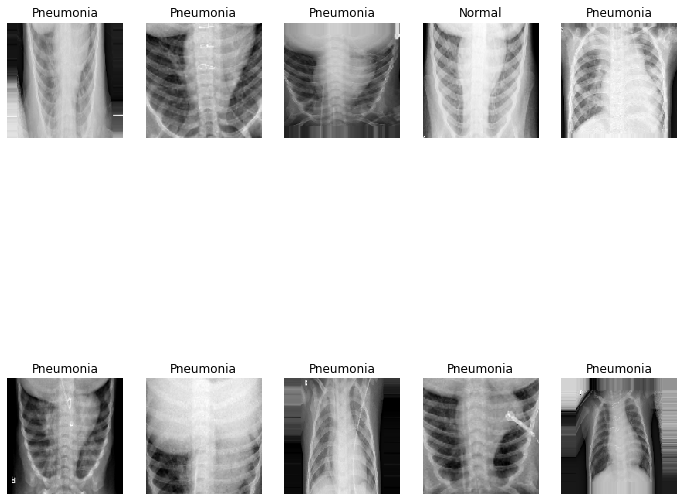

In [178]:
plt.figure(figsize=(12,12))
for i in range(0,10):
  plt.subplot(2,5,i+1)
  for X_batch,Y_batch in train:
    image = X_batch[0]
    dic = {0:'Normal',1:'Pneumonia'}
    plt.title(dic.get(Y_batch[0]))
    plt.axis('off')

    plt.imshow(np.squeeze(image),cmap='gray',interpolation='nearest')
    break

    plt.tight_layout()
    plt.show()

In [179]:
import tensorflow as tf

import os
import keras
from keras.models import Sequential, Model
from keras.layers import Activation, MaxPooling2D, Dropout, Flatten, Reshape, Dense, Conv2D, BatchNormalization, Input, SeparableConv2D, UpSampling2D

from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau
from tqdm.notebook import tqdm

from keras.optimizers import SGD

In [180]:
def SeparableConvBlock(filter_n,kernel_shape,pool_size,init,input_shape,name=None):
    
    input_layer = Input(input_shape)
    
    model = SeparableConv2D(filter_n,kernel_shape,input_shape=(img_width,img_height,1),kernel_initializer=init)(input_layer)
    model = BatchNormalization()(model)
    model = keras.layers.ELU()(model)

    model = SeparableConv2D(filter_n,kernel_shape,kernel_initializer=init)(model)
    model = BatchNormalization()(model)
    model = keras.layers.ELU()(model)


    model = MaxPooling2D(pool_size=pool_size)(model)
    
    return Model(input_layer,model,name=name),model.shape

In [181]:
input_layer = Input(shape=(img_height,img_width,1))

#Encoder

layer,shape = SeparableConvBlock(32,(3,3),(2,2),'glorot_uniform',(img_width,img_height,1),"SPB1")
enc = layer(input_layer)
layer,shape = SeparableConvBlock(64,(3,3),(2,2),'glorot_uniform',(shape[1:]),"SPB2")
enc = layer(enc)
layer,shape = SeparableConvBlock(128,(3,3),(2,2),'glorot_uniform',(shape[1:]),"SPB3")
enc = layer(enc)
layer,shape = SeparableConvBlock(256,(3,3),(2,2),'glorot_uniform',(shape[1:]),"SPB4")
enc = layer(enc)

Encoder = Model(input_layer,enc)

#Decoder

decoder = SeparableConv2D(128, (3, 3), activation='sigmoid', padding='same')(enc)
decoder = BatchNormalization()(decoder)
decoder = SeparableConv2D(128, (3, 3), activation='sigmoid', padding='same')(decoder)
decoder = BatchNormalization()(decoder)
decoder = UpSampling2D((2,2))(decoder)

decoder = SeparableConv2D(64, (3, 3), activation='sigmoid', padding='same')(decoder)
decoder = BatchNormalization()(decoder)
decoder = SeparableConv2D(64, (3, 3), activation='sigmoid', padding='same')(decoder)
decoder = BatchNormalization()(decoder)
decoder = UpSampling2D((2,2))(decoder)

decoder = SeparableConv2D(32, (3, 3), activation='sigmoid', padding='same')(decoder)
decoder = BatchNormalization()(decoder)
decoder = SeparableConv2D(32, (3, 3), activation='sigmoid', padding='same')(decoder)
decoder = BatchNormalization()(decoder)
decoder = UpSampling2D((2,2))(decoder)


decoder = SeparableConv2D(1, (3, 3), activation='sigmoid', padding='same')(decoder)

Decoder = Model(input_layer,decoder)
                
                
#Classifier
flatten = Flatten()(enc)
dense = Dense(128,activation='relu')(flatten)
dense = BatchNormalization()(dense)
dense = Dense(64,activation='relu')(dense)
dense = BatchNormalization()(dense)
dense = Dropout(0.5)(dense)
dense = Dense(1,activation='sigmoid')(dense)

Classifier = Model(input_layer,dense)

In [182]:
Decoder.summary()

Model: "model_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_30 (InputLayer)        [(None, 150, 150, 1)]     0         
_________________________________________________________________
SPB1 (Functional)            (None, 73, 73, 32)        1673      
_________________________________________________________________
SPB2 (Functional)            (None, 34, 34, 64)        7648      
_________________________________________________________________
SPB3 (Functional)            (None, 15, 15, 128)       27584     
_________________________________________________________________
SPB4 (Functional)            (None, 5, 5, 256)         104320    
_________________________________________________________________
separable_conv2d_50 (Separab (None, 5, 5, 128)         35200     
_________________________________________________________________
batch_normalization_84 (Batc (None, 5, 5, 128)         512

In [183]:
Decoder.compile(loss='mean_squared_error', optimizer = SGD())

In [184]:
Decoder.fit(X,Y,batch_size=batch_size,epochs=30)

Epoch 1/30
131/131 [==============================] - 38s 273ms/step - loss: 0.0450
Epoch 2/30
131/131 [==============================] - 36s 273ms/step - loss: 0.0307
Epoch 3/30
131/131 [==============================] - 36s 272ms/step - loss: 0.0266
Epoch 4/30
131/131 [==============================] - 36s 272ms/step - loss: 0.0239
Epoch 5/30
131/131 [==============================] - 36s 276ms/step - loss: 0.0221
Epoch 6/30
131/131 [==============================] - 35s 269ms/step - loss: 0.0208
Epoch 7/30
131/131 [==============================] - 36s 273ms/step - loss: 0.0199
Epoch 8/30
131/131 [==============================] - 36s 274ms/step - loss: 0.0191
Epoch 9/30
131/131 [==============================] - 36s 274ms/step - loss: 0.0184
Epoch 10/30
131/131 [==============================] - 36s 273ms/step - loss: 0.0178
Epoch 11/30
131/131 [==============================] - 36s 275ms/step - loss: 0.0173
Epoch 12/30
131/131 [==============================] - 36s 277ms/step - lo

In [185]:
predictions = Decoder.predict(X)

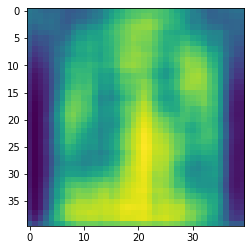

In [186]:
plt.imshow((tf.squeeze(predictions[0])))
plt.show()

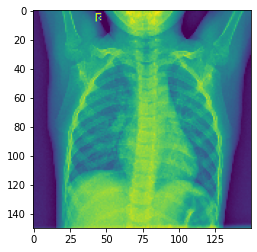

In [187]:
plt.imshow((tf.squeeze(X[0])))
plt.show()

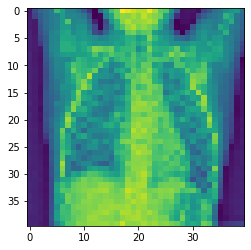

In [188]:
plt.imshow((tf.squeeze(Y[0])))
plt.show()

In [189]:
Classifier.summary()

Model: "model_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_30 (InputLayer)        [(None, 150, 150, 1)]     0         
_________________________________________________________________
SPB1 (Functional)            (None, 73, 73, 32)        1673      
_________________________________________________________________
SPB2 (Functional)            (None, 34, 34, 64)        7648      
_________________________________________________________________
SPB3 (Functional)            (None, 15, 15, 128)       27584     
_________________________________________________________________
SPB4 (Functional)            (None, 5, 5, 256)         104320    
_________________________________________________________________
flatten_4 (Flatten)          (None, 6400)              0         
_________________________________________________________________
dense_12 (Dense)             (None, 128)               819

In [190]:
Classifier.compile(optimizer=SGD(),loss='binary_crossentropy',metrics=['accuracy'])

In [191]:
from sklearn.utils.class_weight import compute_class_weight
weights = compute_class_weight('balanced',np.unique(train.classes),train.classes)
cw = dict(zip(np.unique(train.classes),weights))
print(cw)

{0: 1.9371534195933457, 1: 0.6739549839228296}


In [192]:
Classifier.fit(train,epochs=25,validation_data=valid,class_weight=cw,batch_size=512)

Epoch 1/25
131/131 [==============================] - 70s 519ms/step - loss: 0.5818 - accuracy: 0.7114 - val_loss: 0.3413 - val_accuracy: 0.8740
Epoch 2/25
131/131 [==============================] - 67s 510ms/step - loss: 0.3880 - accuracy: 0.8107 - val_loss: 0.3083 - val_accuracy: 0.8808
Epoch 3/25
131/131 [==============================] - 66s 500ms/step - loss: 0.3246 - accuracy: 0.8559 - val_loss: 0.3011 - val_accuracy: 0.8933
Epoch 4/25
131/131 [==============================] - 66s 500ms/step - loss: 0.3018 - accuracy: 0.8717 - val_loss: 0.4387 - val_accuracy: 0.8154
Epoch 5/25
131/131 [==============================] - 65s 497ms/step - loss: 0.2847 - accuracy: 0.8815 - val_loss: 0.2247 - val_accuracy: 0.9308
Epoch 6/25
131/131 [==============================] - 65s 496ms/step - loss: 0.2546 - accuracy: 0.8916 - val_loss: 0.4697 - val_accuracy: 0.7856
Epoch 7/25
131/131 [==============================] - 65s 493ms/step - loss: 0.2354 - accuracy: 0.9130 - val_loss: 0.2614 - val_ac

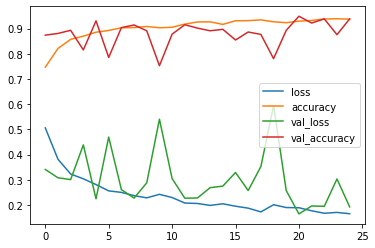

In [193]:
pd.DataFrame(Classifier.history.history).plot()

In [194]:
test_accu = Classifier.evaluate(test)
print('The testing accuracy is - ',test_accu[1]*100,'%')

20/20 [==============================] - 5s 221ms/step - loss: 0.2388 - accuracy: 0.9247
The testing accuracy is -  92.46794581413269 %


In [195]:
from sklearn.metrics import accuracy_score,roc_auc_score,f1_score, log_loss

In [196]:
y_bar = np.round(Classifier.predict(test)).reshape(-1)
y_act = test.labels

In [197]:
##accuracy
print("Accuracy: ",accuracy_score(y_bar,y_act))
##Roc_Auc Score
print("ROC-AUC score: ",roc_auc_score(y_bar,y_act))
##F1-Score Score
print("F1 score: ",f1_score(y_bar,y_act))
##Log Loss Score
print("Log Loss: ",log_loss(y_bar,y_act))

Accuracy:  0.9246794871794872
ROC-AUC score:  0.9303107165504122
F1 score:  0.9416149068322981
Log Loss:  2.601492445725216


In [199]:
Classifier.save('custom_cnn.h5')